<a href="https://colab.research.google.com/github/Hari-Prannav/CodeChef-Task2-NLP/blob/main/CodeChef_Task_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import os
import kagglehub
import numpy as np

In [6]:
# Load Dataset

path = kagglehub.dataset_download("arjoonn/codechef-competitive-programming")
print("Path to dataset files:", path)

# Load 'questions.csv' (main problem statements dataset)
data_path = os.path.join(path, 'questions.csv')
df = pd.read_csv(data_path)
print("Loaded dataset successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns)

Using Colab cache for faster access to the 'codechef-competitive-programming' dataset.
Path to dataset files: /kaggle/input/codechef-competitive-programming
Loaded dataset successfully!
Shape: (1474, 13)
Columns: Index(['QCode', 'Title', 'link', 'level', 'statement', 'Author', 'Tester',
       'Editorial', 'Tags', 'Date Added', 'Time Limit', 'Source Limit',
       'Languages'],
      dtype='object')


In [7]:
# Keep and Clean Required Columns

df = df[['QCode', 'Title', 'statement', 'Tags']].copy()
df.dropna(subset=['statement'], inplace=True)
print("Cleaned dataset shape:", df.shape)

# Combine title + statement for better context
df["text"] = df["Title"].astype(str) + ". " + df["statement"].astype(str)

Cleaned dataset shape: (1474, 4)


In [8]:
# Generate Semantic Embeddings

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["statement"].tolist(), show_progress_bar=True)

from sklearn.preprocessing import StandardScaler

embeddings_scaled = StandardScaler().fit_transform(embeddings)






Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [9]:
# Dimensionality Reduction (UMAP) & Clustering (HDBSCAN)

import umap
import hdbscan

reduced = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(embeddings)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,    # slightly smaller clusters allowed
    min_samples=10,         # less strict density requirement
    metric='euclidean'
)
labels = clusterer.fit_predict(reduced)
df["cluster"] = labels

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
# Cluster Analysis

for cluster_id in set(df["cluster"]):
    print(f"\n--- Cluster {cluster_id} ---")
    sample = df[df["cluster"] == cluster_id].sample(5, random_state=42)
    print(sample["Title"].to_list())


--- Cluster 0 ---
['Sums in a Triangle', 'Painting', 'Chef and Shop', 'Chef of The Ancient', 'Chef and Balanced Strings']

--- Cluster 1 ---
['Two Closest', 'Chef and Cut', 'Chef and His Garden', 'Polo the Penguin and the Tree', 'Sereja and Tree']

--- Cluster -1 ---
['Helping Lira', 'Big Search Trees', 'Lights Off', 'Little Elephant and Bubble Sort', 'Maximum Grid']


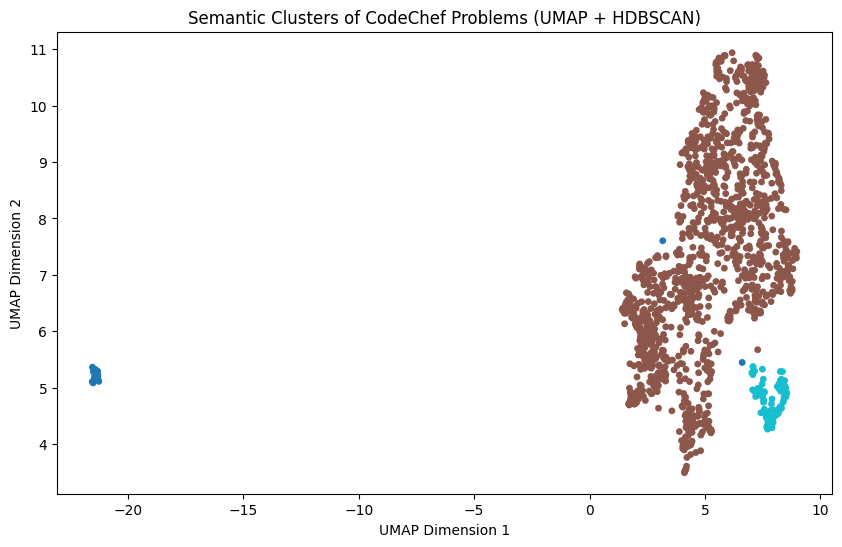

In [13]:
# Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=15)
plt.title("Semantic Clusters of CodeChef Problems (UMAP + HDBSCAN)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [14]:
# Evaluation

from sklearn.metrics import silhouette_score

mask = labels != -1
print("Silhouette Score:", silhouette_score(reduced[mask], labels[mask]))

import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

Silhouette Score: 0.260689
{np.int64(-1): np.int64(48), np.int64(0): np.int64(1331), np.int64(1): np.int64(95)}
